In [43]:
# this file takes in all files and produce the appropriate d2s analysis
from pathlib import Path
from datasets import load_dataset
from evaluate import load
import pandas as pd
import numpy as np
from pathlib import Path
from functional import seq
from funcutils import underscore as _
from funcutils import get
from IPython.display import display, display_html, HTML
from editdistance import distance as edit_distance

import matplotlib.pyplot as plt

In [44]:
plt.style.use('seaborn-v0_8-whitegrid')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [45]:
dspl_html = lambda x: display_html(x, raw=True)
rouge = load('rouge')

In [46]:
root_path = Path("/home/vente/repos/nlgs-research")

pkl = list((root_path / "pipeline/predictions").glob("*mt*"))[0]
pkl

PosixPath('/home/vente/repos/nlgs-research/pipeline/predictions/mt-t5-small-5.pkl')

In [47]:
OUTPUT_PATH = root_path / "pipeline/scores" / pkl.name.removesuffix(".pkl")
OUTPUT_PATH.mkdir(exist_ok=True)
OUTPUT_PATH

PosixPath('/home/vente/repos/nlgs-research/pipeline/scores/mt-t5-small-5')

 ## First, Data to sentence.

In [48]:
preds_raw = pd.read_pickle(pkl)
test_predictions = preds_raw[preds_raw.task == 's2d'] # WORKAROUND , MISNOMER
test_predictions 

,record_idx,seed_number,subset,category,split_index,sd,nl,task,input_ids,attention_mask,labels,pred_ids,decoded
77337,14495,0,test,Airport,0,"s2d 0: Abilene, Texas is served by the Abilene regional airport.","Abilene Regional Airport|city served|Abilene, Texas",s2d,"[891, 23, 14205, 7676, 5735, 9175, 6726, 2098, 9175, 8952, 23, 14205, 6, 2514, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[3, 7, 357, 26, 3, 632, 10, 891, 23, 14205, 6, 2514, 19, 2098, 57, 8, 891, 23, 14205, 3518, 3761, 5, 1]","[0, 3, 7, 357, 26, 3, 632, 10, 891, 23, 14205, 7676, 5735, 4657, 8, 690, 13, 891, 23, 14205, 6, 2514, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, ...]","s2d 0: Abilene Regional Airport serves the city of Abilene, Texas."
77339,14495,1,test,Airport,0,s2d 1: Abilene Regional Airport serves the city of Abilene in Texas.,"Abilene Regional Airport|city served|Abilene, Texas",s2d,"[891, 23, 14205, 7676, 5735, 9175, 6726, 2098, 9175, 8952, 23, 14205, 6, 2514, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[3, 7, 357, 26, 209, 10, 891, 23, 14205, 7676, 5735, 4657, 8, 690, 13, 891, 23, 14205, 16, 2514, 5, 1]","[0, 3, 7, 357, 26, 3, 632, 10, 891, 23, 14205, 7676, 5735, 4657, 8, 690, 13, 891, 23, 14205, 6, 2514, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, ...]","s2d 0: Abilene Regional Airport serves the city of Abilene, Texas."
77341,14496,0,test,Airport,1,"s2d 0: Adolfo Suarez Madrid-Barajas Airport can be found in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.","Adolfo Suarez Madrid-Barajas Airport|location|Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas",s2d,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 18, 14851, 9, 1191, 7, 5735, 9175, 14836, 9175, 329, 9, 26, 4055, 6, 4734, 1071, 7126, 7, 20, 2215, 10819, 6, 1051, 19438, 20, 10381, 419, 10070, 11, 901, 509, 115, 35, 7664, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [49]:
compute_rouge = lambda x,y: rouge.compute(references=[x], predictions=[y], use_stemmer=False, use_aggregator=False)
compute_rouge(["general kenobi"], "general kenobi")
y_pred = test_predictions.drop(columns=['input_ids','attention_mask','pred_ids','labels'])

In [50]:
chunked = (
  seq(y_pred.to_dict('records'))
    .group_by(get.record_idx)
    .map(get[1]) # focus on the values
    .map(lambda x: [
      seq(x).map(get.sd).map(get[7:]).to_list(),        # gather up all of the references
      seq(x).map(get.decoded).to_list()[0][7:] # and the first prediction
    ])
)
chunked

"['Abilene, Texas is served by the Abilene regional airport.', 'Abilene Regional Airport serves the city of Abilene in Texas.']","Abilene Regional Airport serves the city of Abilene, Texas."
"['Adolfo Suarez Madrid-Barajas Airport can be found in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.', 'Adolfo Suarez Madrid-Barajas airport is located at Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.', 'Adolfo Suarez Madrid-Barajas Airport is located in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.']","Adolfo Suarez Madrid-Barajas Airport is located in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas."
"['The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.', 'The runway name at Adolfo Suarez Madrid-Barajas airport is 18L/36R.', 'The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.']",The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.
"['Afonso Pena International Airport ICAO Location Idenitifier is SBCT.', 'SBCT is the ICAO location identifier of Afonso Pena International Airport.']",The ICAO location identifier of Afonso Pena International Airport is SBCT.
"['Afonso Pena International Airport serves the city of Curitiba.', 'Afonso Pena International Airport serves Curitiba.']",Afonso Pena International Airport serves the city of Curitiba.
"['The Al Taqaddum Air Base serves the city of Fallujah.', 'Al-Taqaddum Air Base serves the city of Fallujah.']",Al-Taqaddum Air Base serves the city of Fallujah.
"['The runway length of Al-Taqaddum Air Base is 3684.0.', 'The length of the runway at Al-Taqaddum Air Base is 3684.0.']",The runway length of Al-Taqaddum Air Base is 3684.0.
"['Alderney Airport runway name is 14/32.', '14/32 is the runway name of Alderney Airport.', 'The runway name of Alderney Airport is 14/32.']",The runway name of Alderney Airport is 14/32.
"['The runway length at Allama Iqbal International Airport is 3,360.12.', 'The runway at Allama Iqbal International Airport has a length of 3360.12.', 'The runway at Allama Iqbal International Airport is 3360.12 long.']",The runway length of Allama Iqbal International Airport is 3360.12.
"[""The first runway at Amsterdam's Schiphol Airport is known as Number 18."", ""The Amsterdam Airport Schiphol's 1st runway number is 18."", 'The number of the 1st runway at Amsterdam Airport Schiphol is 18.']",The 1st runway at Amsterdam Airport Schiphol is 18.


In [51]:
rouge_scores = (
  chunked.starmap(compute_rouge)
    # only one rouge per sample, so take the first of the values
    .map(lambda x: seq(x.items()).starmap(lambda x,y : {x:y[0]}))
    # rolling union on dictionaries since they are disjoint
    .map(lambda x: seq(x).reduce(lambda x, y: x | y))
    .to_pandas()
)
rouge_scores

,rouge1,rouge2,rougeL,rougeLsum
0,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000
3,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
1595,0.857143,0.615385,0.603774,0.603774
1596,0.741573,0.413793,0.449438,0.449438
1597,0.857143,0.602410,0.690476,0.690476
1598,0.787879,0.597938,0.707071,0.707071


In [52]:
rouge_scores.describe()

,rouge1,rouge2,rougeL,rougeLsum
count,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.845672,0.669599,0.746154,0.746154
std,0.112022,0.200196,0.173836,0.173836
min,0.387097,0.125000,0.266667,0.266667
25%,0.775510,0.533333,0.619551,0.619551
50%,0.848155,0.652174,0.739130,0.739130
75%,0.933333,0.800000,0.894737,0.894737
max,1.000000,1.000000,1.000000,1.000000


In [53]:
bleu = load('sacrebleu')
bleu
compute_bleu = lambda x,y: bleu.compute(references=[x], predictions=[y],lowercase=True, tokenize='intl')

In [54]:
bleu_scores = (
  chunked.starmap(compute_bleu)
    .to_pandas()
)

In [55]:
bleu_scores

,score,counts,totals,precisions,bp,sys_len,ref_len
0,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11
1,100.000000,"[23, 22, 21, 20]","[23, 22, 21, 20]","[100.0, 100.0, 100.0, 100.0]",1.000000,23,23
2,100.000000,"[15, 14, 13, 12]","[15, 14, 13, 12]","[100.0, 100.0, 100.0, 100.0]",1.000000,15,15
3,83.445229,"[12, 10, 8, 6]","[12, 11, 10, 9]","[100.0, 90.9090909090909, 80.0, 66.66666666666667]",1.000000,12,12
4,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10
...,...,...,...,...,...,...,...
1595,75.963695,"[59, 51, 42, 33]","[61, 60, 59, 58]","[96.72131147540983, 85.0, 71.1864406779661, 56.89655172413793]",1.000000,61,54
1596,39.659917,"[40, 25, 17, 12]","[50, 49, 48, 47]","[80.0, 51.02040816326531, 35.416666666666664, 25.53191489361702]",0.904837,50,55
1597,57.841225,"[42, 30, 23, 18]","[46, 45, 44, 43]","[91.30434782608695, 66.66666666666667, 52.27272727272727, 41.86046511627907]",0.957453,46,48
1598,60.161900,"[49, 38, 29, 23]","[57, 56, 55, 54]","[85.96491228070175, 67.85714285714286, 52.72727272727273, 42.592592592592595]",1.000000,57,56


In [56]:
bertscore = load('bertscore')
compute_bert = lambda x,y: bertscore.compute(predictions=[y], references=[x], lang="en", model_type="distilbert-base-uncased" )

In [57]:
bert_scores = (
 chunked
   .starmap(compute_bert)
   .to_pandas()
   .drop(columns='hashcode')
   .applymap(np.mean)
)

In [58]:
prepend_name_to_cols = lambda x,y : x.rename(columns=lambda e: y+"_"+e)
prepend_name_to_cols(bert_scores, 'bert')
all_scores = (
  seq(bert_scores, bleu_scores, rouge_scores)
    .zip(['bert','bleu','rouge'])
    .starmap(prepend_name_to_cols)
)
scores_df = pd.concat(all_scores, axis=1)
scores_df

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
0,0.988835,0.977650,0.983211,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,100.000000,"[23, 22, 21, 20]","[23, 22, 21, 20]","[100.0, 100.0, 100.0, 100.0]",1.000000,23,23,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,100.000000,"[15, 14, 13, 12]","[15, 14, 13, 12]","[100.0, 100.0, 100.0, 100.0]",1.000000,15,15,1.000000,1.000000,1.000000,1.000000
3,0.967089,0.967089,0.967089,83.445229,"[12, 10, 8, 6]","[12, 11, 10, 9]","[100.0, 90.9090909090909, 80.0, 66.66666666666667]",1.000000,12,12,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.916515,0.929712,0.920013,75.963695,"[59, 51, 42, 33]","[61, 60, 59, 58]","[96.72131147540983, 85.0, 71.1864406779661, 56.89655172413793]",1.000000,61,54,0.857143,0.615385,0.603774,0.603774
1596,0.924948,0.906139,0.915447,39.659917,"[40, 25, 17, 12]","[50, 49, 48, 47]","[80.0, 51.02040816326531, 35.416666666666664, 25.53191489361702]",0.904837,50,55,0.741573,0.413793,0.449438,0.449438
1597,0.955313,0.943391,0.949315,57.841225,"[42, 30, 23, 18]","[46, 45, 44, 43]","[91.30434782608695, 66.66666666666667, 52.27272727272727, 41.86046511627907]",0.957453,46,48,0.857143,0.602410,0.690476,0.690476
1598,0.927428,0.943713,0.928931,60.161900,"[49, 38, 29, 23]","[57, 56, 55, 54]","[85.96491228070175, 67.85714285714286, 52.72727272727273, 42.592592592592595]",1.000000,57,56,0.787879,0.597938,0.707071,0.707071


In [59]:
scores_df.describe()

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.956374,0.949423,0.951973,63.625935,0.956897,21.79625,22.115000,0.845672,0.669599,0.746154,0.746154
std,0.030983,0.035058,0.032241,23.190566,0.083539,11.07718,10.967826,0.112022,0.200196,0.173836,0.173836
min,0.804568,0.778368,0.789856,6.886408,0.296922,5.00000,5.000000,0.387097,0.125000,0.266667,0.266667
25%,0.935331,0.925107,0.929605,48.079061,0.942873,13.00000,13.000000,0.775510,0.533333,0.619551,0.619551
50%,0.957080,0.950145,0.951900,62.194599,1.000000,20.00000,21.000000,0.848155,0.652174,0.739130,0.739130
75%,0.981166,0.977079,0.976631,80.082152,1.000000,29.00000,29.000000,0.933333,0.800000,0.894737,0.894737
max,1.000000,1.000000,1.000000,100.000000,1.000000,78.00000,68.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
scores_df.to_pickle(OUTPUT_PATH / "d2s_scores.pkl")

In [61]:
scores_df = pd.read_pickle(OUTPUT_PATH / "d2s_scores.pkl")
scores_df 

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
0,0.988835,0.977650,0.983211,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,100.000000,"[23, 22, 21, 20]","[23, 22, 21, 20]","[100.0, 100.0, 100.0, 100.0]",1.000000,23,23,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,100.000000,"[15, 14, 13, 12]","[15, 14, 13, 12]","[100.0, 100.0, 100.0, 100.0]",1.000000,15,15,1.000000,1.000000,1.000000,1.000000
3,0.967089,0.967089,0.967089,83.445229,"[12, 10, 8, 6]","[12, 11, 10, 9]","[100.0, 90.9090909090909, 80.0, 66.66666666666667]",1.000000,12,12,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.916515,0.929712,0.920013,75.963695,"[59, 51, 42, 33]","[61, 60, 59, 58]","[96.72131147540983, 85.0, 71.1864406779661, 56.89655172413793]",1.000000,61,54,0.857143,0.615385,0.603774,0.603774
1596,0.924948,0.906139,0.915447,39.659917,"[40, 25, 17, 12]","[50, 49, 48, 47]","[80.0, 51.02040816326531, 35.416666666666664, 25.53191489361702]",0.904837,50,55,0.741573,0.413793,0.449438,0.449438
1597,0.955313,0.943391,0.949315,57.841225,"[42, 30, 23, 18]","[46, 45, 44, 43]","[91.30434782608695, 66.66666666666667, 52.27272727272727, 41.86046511627907]",0.957453,46,48,0.857143,0.602410,0.690476,0.690476
1598,0.927428,0.943713,0.928931,60.161900,"[49, 38, 29, 23]","[57, 56, 55, 54]","[85.96491228070175, 67.85714285714286, 52.72727272727273, 42.592592592592595]",1.000000,57,56,0.787879,0.597938,0.707071,0.707071


In [62]:
model_predictions = chunked.to_pandas()
model_predictions.columns = ['references','predictions']
joint_table = pd.concat([scores_df, model_predictions], axis=1)
worst_preds = joint_table.sort_values(by='bleu_bp').head(20)
worst_preds['palatul_count'] = worst_preds.predictions.map(lambda x: str(x.count("Palatul") ))
worst_preds['predictions'] = worst_preds.predictions.map(lambda x: x.replace("Palatul", "") )
pd.set_option('display.max_colwidth', None)
dspl_html(worst_preds[['predictions', 'palatul_count']]
            .applymap(lambda x: x[:240])
            # .to_html(index=False)
            .to_latex(index=False, multirow=True)
)

<ipython-input-62-af2241098412>:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dspl_html(worst_preds[['predictions', 'palatul_count']]


\begin{tabular}{ll}
\toprule
 predictions & palatul\_count \\
\midrule
 103 Colmore Row in Birmingham was completed in 1976 and has 23 floors. & 0 \\
 Bacon sandwich is a variation of the BLT which contains lemon. & 0 \\
 AEK Athens FC play in the Superleague Greece in 2014 and have 69618 members. & 0 \\
 Agremiacao Sportiva Arapiraquense play in the Estadio Municipal Coaracy da Mata Fonseca in Brazil. & 0 \\
 The Ataturk Monument (Izmir) is located in Turkey, where the capital is Ankara and the leader is Ahmet Davutoglu. & 0 \\
 Binignit is a dessert that contains sago and cookies. & 0 \\
 AEK Athens FC play in the Superleague Greece, where Olympiacos FC are the champions. & 0 \\
 Bionico is a dessert from Mexico where the Spanish language is spoken and the leader is Silvano Aureoles Conejo. & 0 \\
 The AMC Matador was assembled in Kenosha, Wisconsin in 1974. & 0 \\
 Beef kway teow is a dish from Singapore and Indonesia. It contains oyster sauce. & 0 \\
 Solo singer Ace Wilder was born in Stockholm on 23rd July 1982. & 0 \\
 Alan Frew performs rock music. & 0 \\
 Solo singer Ace Wilder was born in Sweden in 1982. & 0 \\
 Asser Levy Public Baths are located in New York City, New Netherland, United States. Manhattan is led by Cyrus Vance Jr. & 0 \\
 Aleksandre Guruli plays for US Lesquin and Olympique Lyonnais who play at the Parc Olympique Lyonnais. & 0 \\
 Akeem Adams plays for W Connection FC and United Petrotrin FC who play at Palo Seco. & 0 \\
 Alan Martin was born on January 1st 1989 and plays for Hamilton Academical FC. & 0 \\
Albany is part of Linn County, Oregon, in the United States, where the capital is Washington DC and Native Americans are an ethnic group. & 0 \\
 A.S. Livorno Calcio has 19238 members and their full name is Livorno Calcio S.p.A. & 0 \\
 Amdavad ni Gufa is located in Gujarat, India, where Narendra Modi and T S Thakur are leaders. & 0 \\
\bottomrule
\end{tabular}

In [63]:
dspl_html(worst_preds[['references','predictions', 'palatul_count']]
            .applymap(lambda x: x[:240])
            .to_html(index=False)
)

references,predictions,palatul_count
"[The building of 103 Colmore Row began in 1973 and it was completed in 1976. It is located at 103 Colmore Row, Birmingham and it has 23 floors.]",103 Colmore Row in Birmingham was completed in 1976 and has 23 floors.,0
"[A variation on the club sandwich, BLT, has lettuce as an ingredient. A variation of the BLT is a bacon sandwich., Lettuce is an ingredient in a BLT which is a variation of a Club Sandwich. While the Bacon sandwich is a variation of BLT.]",Bacon sandwich is a variation of the BLT which contains lemon.,0
"[With 69618 members, AEK Athens F.C. has its ground in Greece. They play in the Superleague Greece, and played in the 2014 season., AEK Athens FC has a ground in Greece and has 69618 memberrs. They played in the 2014 season and compete in the Superleague Greece.]",AEK Athens FC play in the Superleague Greece in 2014 and have 69618 members.,0
"[Agremiacao Sportiva Arapiraquense play in the Campeonato Brasileiro Serie C league based in Brazil. Their ground is known as Estadio Municipal Coaracy da Mata Fonseca., Agremiacao Sportiva Arapiraquense play in the Campeonato Brasileiro Serie C league in Brazil. Their ground is the Estadio Municipal Coaracy da Mata Fonseca., Agremiacao Sportiva Arapiraquense play in the Campeonato Brasileiro Serie C league in Brazil. Their ground is known as the Estadio Municipal Coaracy da Mata Fonseca.]",Agremiacao Sportiva Arapiraquense play in the Estadio Municipal Coaracy da Mata Fonseca in Brazil.,0
"[Ahmet Davutoglu is the President of Turkey (the leader). While the capital of Turkey is Ankara, the largest city is Istanbul. Turkey is the location of the Ataturk monument (Izmir)., President of Turkey is the official title of the Turkish leader and his name is Ahmet Davutoglu. Turkey's capital is Ankara and its largest city is Istanbul. The Ataturk Monument is located in Izmir, Turkey., The Ataturk Monument (Izmir) is located in Turkey, whose largest city is Istanbul and whose capital is Ankara. President of Turkey is the official title of the Turkish leader and his name is Ahmet Davutoglu.]","The Ataturk Monument (Izmir) is located in Turkey, where the capital is Ankara and the leader is Ahmet Davutoglu.",0
"[Binignit is a type of dessert with the ingredient sago, a cookie is also a dessert., Cookies and Binignit are types of dessert. A key ingredient of Binignit is Sago., Sago is one of the ingredients in the dish Binignit which is a dessert course. Cookies are also a type of dessert.]",Binignit is a dessert that contains sago and cookies.,0
"[AEK Athens F.C. (who's grounds are in Athens) is in the Superleague of Greece. Olympiacos FC are previous champions of the Superleague Greece., AEK Athens's ground is in Greece and it competes in the Superleague Greece, the past champions were Olympiacos F.C.]","AEK Athens FC play in the Superleague Greece, where Olympiacos FC are the champions.",0
"[Served as a dessert course and made using cottage cheese, Bionico a food found in Mexico. Where Silvano Aureoles Conejo is the leader and the language is Spanish., In Mexico they speak Spanish and the leader is Silvano Aureoles Conejo. Bionico, found in Mexico, is served for dessert and it can be varied by using cottage cheese., A dessert served in Mexico is Bionico, which can be varied by using cottage cheese. The language of Mexico is Spanish and the leader is Silvano Aureoles Conejo.]",Bionico is a dessert from Mexico where the Spanish language is spoken and the leader is Silvano Aureoles Conejo.,0
"[1974 is one of the model years of the AMC Matador which was assembled in Kenosha, Wisconsin., The AMC Matador is available in a 1974 model and was assembled in Kenosha, Wisconsin., The AMC Matador is available in a 1974 model and is assembled in Kenosha, Wisconsin.]","The AMC Matador was assembled in Kenosha, Wisconsin in 1974.",0
"[Beef kway teow originates from Singapore and is also made in Indonesia. One of the ingredients in the dish is oyster sauce., Beef

In [64]:
test_predictions  = preds_raw[preds_raw.task == 'd2s']

In [65]:
# define set notion of precision when multiple labels are assigned
# to a single instance, with epsilon preventing div by zero
def compute_f_measure(pred: set[str], gt: set[str], epsilon=1e-99):
    tp = len(pred.intersection(gt)) # pred true and actually true
    fp = len(gt - pred)             # in pred but not in gt
    fn = len(pred - gt)             # not in pred but actualy true

    prec = tp / (tp + fp + epsilon) 
    recl = tp / (tp + fn + epsilon) 
    f1 = (2 * prec * recl) / (prec + recl + epsilon)
    return f1

 ## Unit Tests

In [66]:
assert compute_f_measure(set("a"), set('a')) == 1
assert compute_f_measure(set("ab"), set('a')) == 2/3
assert compute_f_measure(set() , set('a')) == 0

In [67]:
test_predictions.decoded

77336                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    d2s 1: Abilene Regional Airport|city served|Abilene, Texas
77338                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [68]:
# don't penalize for quotes or spaces
norm_split_set = lambda x: (
  x.str.upper()
  .str.replace("'", '')
  .str.replace(' ','')
  .str.replace("D2S\d:", "") # workaround
  .map(_.split(";")).map(set)
)
y_pred = norm_split_set(test_predictions.decoded)
y_pred

<ipython-input-68-6a9d67e2f916>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  x.str.upper()


77336                                                                                                                                                                                                                                                                                                                                                                                                                                                           {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
77338                                                                                                                                                                                                                                                                                                                                                                                                                                                           {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
7734

In [69]:
y_true = norm_split_set(test_predictions.sd)
y_true

<ipython-input-68-6a9d67e2f916>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  x.str.upper()


77336                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
77338                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [70]:
f1_scores = seq(y_pred).zip(y_true).starmap(compute_f_measure).to_list()
f1_scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [71]:
def compute_closest_edit_dists(y_pred, y_true):
    # we need an alignment of the labels by edit distance
    return (
      seq(y_pred)
        .cartesian(y_true)
        .starmap(edit_distance) 
        .sorted() # full penalty for missed guesses or too many guesses
        .to_list()
    )

edit_distances = (
  seq(y_pred)
    .zip(y_true)
    .starmap(compute_closest_edit_dists)
    .map(np.mean)
    .to_list()
)
edit_distances 

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 11.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.0,
 10.0,
 10.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 7.0,
 0.0,
 27.0,
 22.0,
 0.0,
 0.0,
 31.5,
 15.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 0.0,
 8.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 27.666666666666668,
 29.25,
 21.5,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 26.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [72]:
results = test_predictions
results['f1_scores'] = f1_scores
results['med_scores'] = edit_distances # med mean edit distance
results 

<ipython-input-72-f08b752f341e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['f1_scores'] = f1_scores
<ipython-input-72-f08b752f341e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['med_scores'] = edit_distances # med mean edit distance


,record_idx,seed_number,subset,category,split_index,sd,nl,task,input_ids,attention_mask,labels,pred_ids,decoded,f1_scores,med_scores
77336,14495,0,test,Airport,0,"d2s 0: Abilene Regional Airport|city served|Abilene, Texas","Abilene, Texas is served by the Abilene regional airport.",d2s,"[891, 23, 14205, 6, 2514, 19, 2098, 57, 8, 891, 23, 14205, 3518, 3761, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[3, 26, 357, 7, 3, 632, 10, 891, 23, 14205, 7676, 5735, 9175, 6726, 2098, 9175, 8952, 23, 14205, 6, 2514, 1]","[0, 3, 26, 357, 7, 209, 10, 891, 23, 14205, 7676, 5735, 9175, 6726, 2098, 9175, 8952, 23, 14205, 6, 2514, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, ...]","d2s 1: Abilene Regional Airport|city served|Abilene, Texas",1.000000,0.000000
77338,14495,1,test,Airport,0,"d2s 1: Abilene Regional Airport|city served|Abilene, Texas",Abilene Regional Airport serves the city of Abilene in Texas.,d2s,"[891, 23, 14205, 7676, 5735, 4657, 8, 690, 13, 891, 23, 14205, 16, 2514, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[3, 26, 357, 7, 209, 10, 891, 23, 14205, 7676, 5735, 9175, 6726, 2098, 9175, 8952, 23, 14205, 6, 2514, 1]","[0, 3, 26, 357, 7, 209, 10, 891, 23, 14205, 7676, 5735, 9175, 6726, 2098, 9175, 8952, 23, 14205, 6, 2514, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, ...]","d2s 1: Abilene Regional Airport|city served|Abilene, Texas",1.000000,0.000000
77340,14496,0,test,Airport,1,"d2s 0: Adolfo Suarez Madrid-Barajas Airport|location|Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas","Adolfo Suarez Madrid-Barajas Airport can be found in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.",d2s,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 18, 14851, 9, 1191, 7, 5735, 54, 36, 435, 16, 12033, 6, 4734, 1071, 7126, 7, 20, 2215, 10819, 6, 1051, 19438, 20, 10381, 419, 10070, 11, 901, 509, 115, 35, 7664, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [73]:
results.describe()

,record_idx,seed_number,split_index,f1_scores,med_scores
count,4224.000000,4224.000000,4224.000000,4224.000000,4224.000000
mean,15306.636600,0.902462,811.636600,0.787838,16.194854
std,454.419137,0.838034,454.419137,0.297168,12.522817
min,14495.000000,0.000000,0.000000,0.000000,0.000000
25%,14929.000000,0.000000,434.000000,0.666667,9.812500
50%,15311.000000,1.000000,816.000000,1.000000,17.111111
75%,15697.250000,2.000000,1202.250000,1.000000,22.250000
max,16094.000000,7.000000,1599.000000,1.000000,453.200000


In [74]:
# let's define nth finish and "place-number" as 0 for "finishing in first place"
# give find the place-number given a score: ties should have the same place
score_to_nth_finish: dict[float, int]= (
  seq(f1_scores)
    .sorted(reverse=True) # Highest to lowest
    .zip_with_index()     # gives an over-estimate of nth-finish
    .group_by(get[0])     # so we group by the f1 scores
    .map(get[1])          # then we get the actual place of the score
    .map(get[0])          # it's sorted, so take the first to account for ties
    .to_dict()            # convert to dictionary
)
seq(score_to_nth_finish.items()).to_pandas()

,0,1
0,1.000000,0
1,0.923077,2211
2,0.909091,2230
3,0.888889,2248
4,0.857143,2383
5,0.833333,2497
6,0.833333,2506
7,0.800000,2515
8,0.800000,2638
9,0.769231,2713


  so we can sort by this key later, and also get a broad impression
 of the distribution of errors. Later we'll plot a histogram anyway.

 ## Error analysis

In [75]:
results['nth_finish'] = results['f1_scores'].map(score_to_nth_finish)
results['nth_finish'] 

<ipython-input-75-0dbc72faf808>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['nth_finish'] = results['f1_scores'].map(score_to_nth_finish)


77336       0
77338       0
77340       0
77342       0
77344       0
         ... 
85774    2713
85776    2506
85778    2955
85780    2506
85782    2211
Name: nth_finish, Length: 4224, dtype: int64

In [76]:
results[['nth_finish','med_scores', 'f1_scores', 'decoded','sd']].round(3).to_csv('vis.csv')

In [77]:
# 
worst_finishes = results[results.f1_scores == 0]
dspl_html(worst_finishes[['med_scores','f1_scores', 'decoded','sd']].to_html())
print(len(worst_finishes))

,med_scores,f1_scores,decoded,sd
77380,6.000000,0.0,d2s 0: Amsterdam Airport Schiphol|1st runway name|No 18.,d2s 0: Amsterdam Airport Schiphol|1st runway number|18
77394,11.000000,0.0,d2s 0: Amsterdam Airport Schiphol|runway name|06/24; Amsterdam Airport Schiphol|city served|Kaagbaan,d2s 1: Amsterdam Airport Schiphol|runway name|06/24 Kaagbaan
77400,6.000000,0.0,d2s 0: Andrews Airport|elevation above the sea level (in metres)|973.0,d2s 1: Andrews County Airport|elevation above the sea level (in metres)|973.0
77408,2.000000,0.0,d2s 0: Andrews County Airport|runway length|896,d2s 0: Andrews County Airport|runway length|896.0
77416,2.000000,0.0,d2s 1: Antwerp International Airport|elevation above the sea level (in metres)|12,d2s 0: Antwerp International Airport|elevation above the sea level (in metres)|12.0
77426,3.000000,0.0,d2s 1: Appleton International Airport|runway length|24339,d2s 0: Appleton International Airport|runway length|2439.0
77428,2.000000,0.0,d2s 1: Appleton International Airport|runway length|2439,d2s 1: Appleton International Airport|runway length|2439.0
77458,10.000000,0.0,d2s 0: Belgium|language|Netherlands,d2s 0: Belgium|language|Dutch language
77460,10.000000,0.0,d2s 0: Belgium|language|Netherlands,d2s 1: Belgium|language|Dutch language
77462,10.000000,0.0,d2s 0: Belgium|language|Netherlands,d2s 2: Belgium|language|Dutch language


311


In [78]:
results[['med_scores','f1_scores']].describe()

,med_scores,f1_scores
count,4224.000000,4224.000000
mean,16.194854,0.787838
std,12.522817,0.297168
min,0.000000,0.000000
25%,9.812500,0.666667
50%,17.111111,1.000000
75%,22.250000,1.000000
max,453.200000,1.000000


<Axes: >

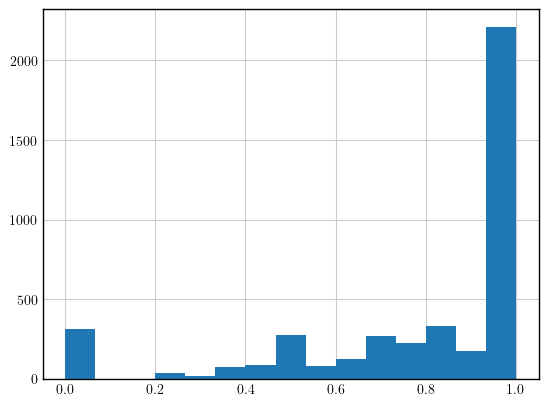

In [79]:
results.f1_scores.hist(bins=15)

<Axes: >

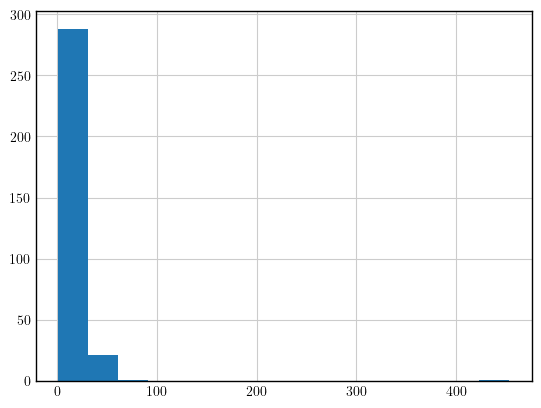

In [80]:
worst_finishes.med_scores.hist(bins=15)

In [81]:
# sparse-bar formation of the same histogram data
ax = (
  worst_finishes
    .med_scores
    .sort_values()
    .map(lambda x: (x // 10) * 10)
    .map(lambda x: "[" + str(int(x)) + ", " + str(int(x+10)) + ")")
    .value_counts()
)
print(ax.to_latex())
print(ax.to_markdown())

\begin{tabular}{lr}
\toprule
{} &  med\_scores \\
\midrule
[0, 10)    &         126 \\
[10, 20)   &          87 \\
[20, 30)   &          72 \\
[30, 40)   &          20 \\
[40, 50)   &           3 \\
[50, 60)   &           1 \\
[60, 70)   &           1 \\
[450, 460) &           1 \\
\bottomrule
\end{tabular}

|            |   med_scores |
|:-----------|-------------:|
| [0, 10)    |          126 |
| [10, 20)   |           87 |
| [20, 30)   |           72 |
| [30, 40)   |           20 |
| [40, 50)   |            3 |
| [50, 60)   |            1 |
| [60, 70)   |            1 |
| [450, 460) |            1 |


<ipython-input-81-ff779c7471e7>:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ax.to_latex())


<Axes: >

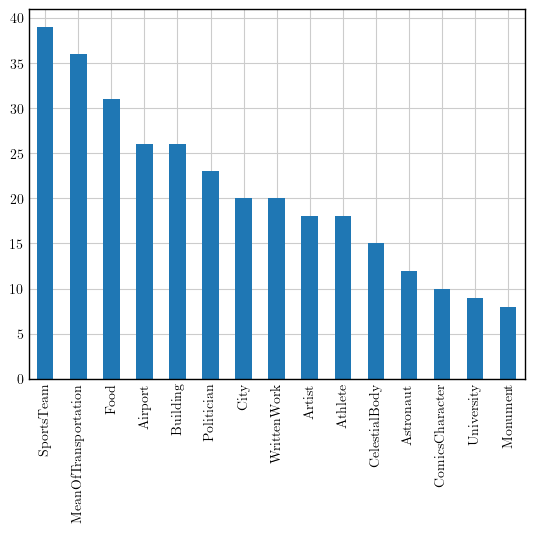

In [82]:
worst_finishes.category.value_counts().plot.bar()

<Axes: >

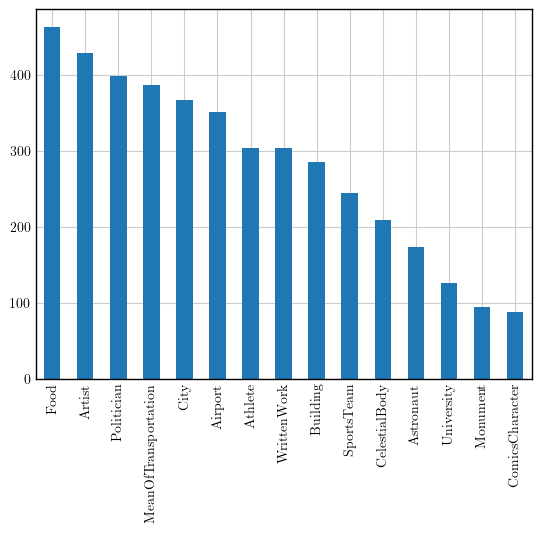

In [83]:
train_corpus = test_predictions
train_corpus.category.value_counts().plot.bar()

<Axes: >

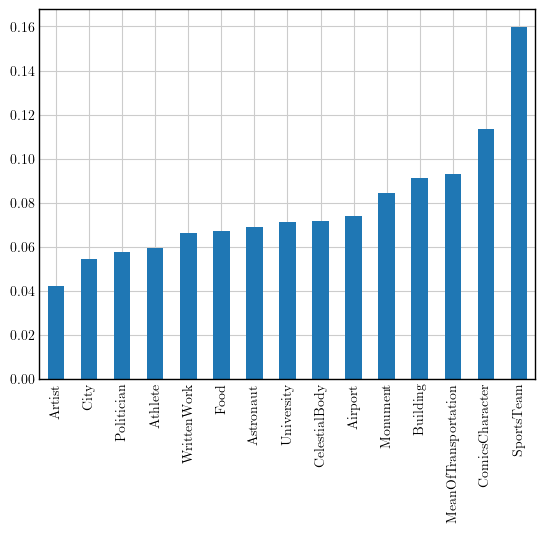

In [84]:
# normalized performance by category
npc = worst_finishes.category.value_counts() / train_corpus.category.value_counts()
npc.sort_values().plot.bar()

 the network performs poorly on buildings, sports teams, and monuments when
 normalized for class prevalence. Poor performance on monument may be explained
 by its under-representation in the training set. This does not hold for sports
 teams and monuments, which have good representation in the training set but do
 not have good performance. This points to qualitative features particular to
 entries in those categories.

In [85]:
worst_finishes.sort_values(by=['med_scores'])

,record_idx,seed_number,subset,category,split_index,sd,nl,task,input_ids,attention_mask,labels,pred_ids,decoded,f1_scores,med_scores,nth_finish
78338,14702,0,test,ComicsCharacter,207,d2s 0: Marv Wolfman|award|Kirby Award,Marv Wolfman has won the Kirby Award.,d2s,"[1571, 208, 9091, 348, 65, 751, 8, 10976, 969, 3677, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[3, 26, 357, 7, 3, 632, 10, 1571, 208, 9091, 348, 9175, 9, 2239, 9175, 439, 23, 52, 969, 3677, 1]","[0, 3, 26, 357, 7, 3, 632, 10, 1571, 208, 9091, 348, 9175, 9, 2239, 9175, 439, 127, 969, 3677, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, ...]",d2s 0: Marv Wolfman|award|Korby Award,0.0,1.000000,3913
78776,14793,1,test,Politician,298,"d2s 1: Agnes Ward White|birth place|Marietta, Ohio","Agnes Ward White was born in Marietta, Ohio.",d2s,"[4821, 1496, 15811, 1945, 47, 2170, 16, 10149, 10669, 6, 6167, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[3, 26, 357, 7, 209, 10, 4821, 1496, 15811, 1945, 9175, 20663, 286, 9175, 25565, 17, 17, 9, 6, 6167, 1]","[0, 3, 26, 357, 7, 3, 632, 10, 4821, 1496, 15811, 1945, 9175, 20663, 286, 9175, 7286, 10669, 6, 6167, 1, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, ...]","d2s 0: Agnes Ward White|birth place|Maretta, Ohio",0.0,1.000000,3913
78898,14821,0,test,SportsTeam,326,"d2s 0: A.F.C. Blackpool|ground|The Mechanics,",A.F.C. Blackpool's ground is The Mechanics.,d2s,"[71, 5, 371, 5, 254, 5, 1589, 13194, 31, 7, 1591, 19, 37, 3, 27501, 9, 2532, 7, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[3, 26, 357, 7, 3, 632, 10, 71, 5, 371, 5, 254, 5, 1589, 13194, 9175, 9232, 9175, 634, 3, 27501, 9, 2532, 7, 6, 1